# Testing the coefficients in a real simulation where the feedback is generated by the readout.

In [1]:
# Makes possible to show the output from matplotlib inline
%matplotlib inline
import matplotlib.pyplot as plt

# Makes the figures in the PNG format:
# For more information see %config InlineBackend
%config InlineBackend.figure_formats=set([u'png'])

# plt.rcParams['figure.figsize'] = 5, 10

import numpy
import sys
import os

import save_load_file as slf

from generates_lsm_start import *

# Main functions to the 2 joint arm simulation

In [1]:
from simulation_2DoF_Arm_physics import *

# Start of the simulation!

In [3]:
# Experiment identifier
sim_sets = ["set_A", "set_B", "set_C", "set_D"]

sim_set = sim_sets[0]

base_dir = "2DofArm_simulation_data"

trajectories = [[[0.75,0.25],[0.0,0.5]],\
                [[0.25,0.60],[-0.25,0.60]],\
                [[-0.10,0.75],[-0.10,0.25]],\
                [[-0.75,0.50],[-0.40,0.00]]]

In [4]:
# First the arm parametres according to Joshi/Maass paper
aparams = {
    'l1' : 0.5, # metres
    'l2' : 0.5,
    'lc1' : 0.25,
    'lc2' : 0.25,
    'm1' : 1.0, # kg
    'm2' : 1.0,
    'i1' : 0.03, # kg*m*m
    'i2' : 0.03
}

In [5]:
# Total time spent during the movement (in seconds)
MT = 0.5
# Simulation time step (in seconds)
time_step = 2/1000.0
# Number of neurons at each input layer (defines the resolution of the system)
Ninput = 50

In [6]:
t_mov=numpy.arange(0, MT, time_step) # t starts in 0s and steps time_step(s) until reaches MT(s)

In [7]:
# Reads all the experiments to check which range of torques is necessary to control the arm
# These values are based ONLY in the 4 trajectories used!
torques_all_1 = numpy.array([]);
torques_all_2 = numpy.array([]);
number_of_trajectories = len(trajectories)
for i in range(1,number_of_trajectories+1):
    states,torques = slf.load_from_file_gz("./"+base_dir+"/"+sim_set+"/States_Torques_movement"+str(i)+".gzpickle")
    torques_all_1 = numpy.concatenate((torques_all_1,torques[:,0])) # torques joint 1
    torques_all_2 = numpy.concatenate((torques_all_2,torques[:,1])) # torques joint 2

In [8]:
# Creates the 50 possible discrete values of torques for each joint (probably will be different)
torques_values_1=numpy.linspace(torques_all_1.min(),torques_all_1.max(),num=50)
torques_values_2=numpy.linspace(torques_all_2.min(),torques_all_2.max(),num=50)

In [9]:
# Creates the 50 possible discrete values of angles for each joint
teta1_values=numpy.linspace(-numpy.pi/6,numpy.pi,num=50)
teta2_values=numpy.linspace(0,numpy.pi,num=50)

In [10]:
# These are the 50 possible values that the input neurons will represent (x,y) 
x_values=numpy.linspace(-1,1,num=50)
y_values=numpy.linspace(-1,1,num=50)

## Loads the coefficients generated by the linear regression:

In [11]:
[c_tau1,r_tau1] = slf.load_from_file("./"+base_dir+"/"+sim_set+"/coefficients_residues_tau1_08-05-15.pickle")
[c_tau2,r_tau2] = slf.load_from_file("./"+base_dir+"/"+sim_set+"/coefficients_residues_tau2_08-05-15.pickle")

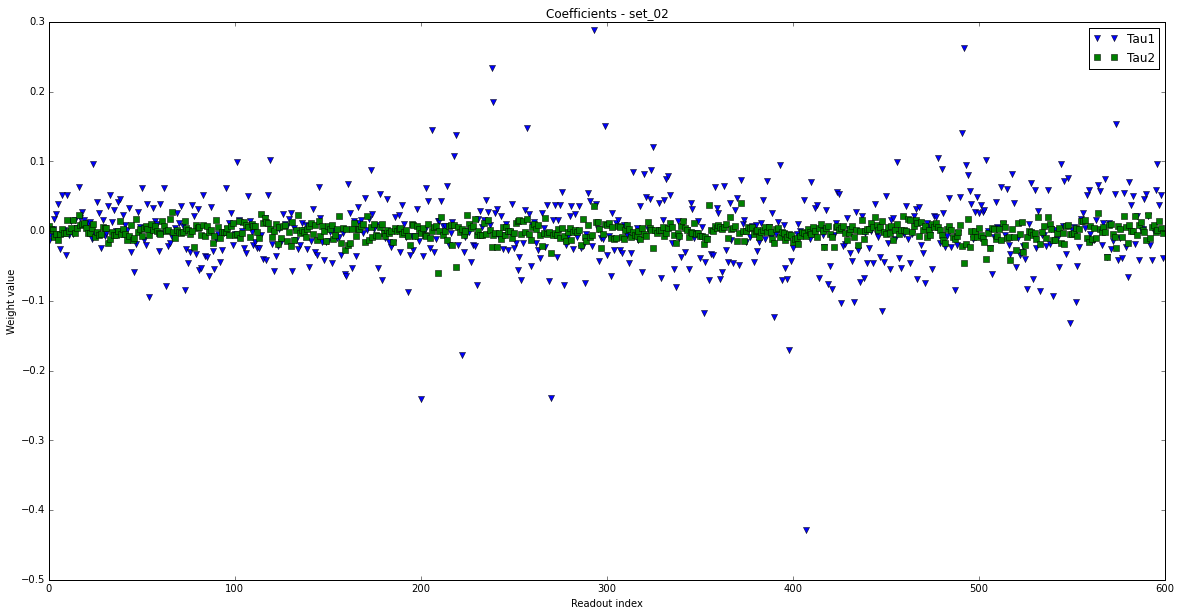

In [12]:
plt.figure(figsize =(20,10))
plt.plot(c_tau1,'v',label="Tau1")
plt.plot(c_tau2,'s',label="Tau2")
plt.title("Coefficients - " + sim_set)
plt.xlabel("Readout index")
plt.ylabel("Weight value")
plt.legend()
plt.savefig(os.getcwd()+"/"+base_dir+"/"+"coefficients_"+sim_set+".pdf")
plt.show()

# DON'T FORGET TO SET PROPERLY THE SIMULATION'S VARIABLES!

In [14]:
def new_experiment():
    global run_number
    run_number+=1
    #####DEBUG
    #####Reads exactly the same input spikes using during the training to check if the system is reproducing the same simulation!
    # inputs_training = slf.load_from_file_gz("./"+base_dir+"/"+sim_set+"/States_Torques_movement"+str(tji)+"_INPUTS_LSM_1.gzpickle")
    # tau_temp = []
    # teta_temp = []
    # torque_idx = []
    #####END_DEBUG

    import numpy
    import time
    import save_load_file as slf

    import step_by_step_brian
    reload(sys.modules['step_by_step_brian']) # Makes sure the interpreter is going to reload the module
    step_by_step_brian_sim = step_by_step_brian.step_by_step_brian_sim


    #
    # It's necessary to uncomment the import statement according to which parameters should be used
    #

    # Simulator based on Joshi/Maass 2006 parameters
    import simulation_2DoF_Arm_md 
    reload(sys.modules['simulation_2DoF_Arm_md']) # Makes sure the interpreter is going to reload the module
    simulation_2DoF_Arm = simulation_2DoF_Arm_md.simulation_2DoF_Arm

    import membrane_lowpass_md
    reload(sys.modules['membrane_lowpass_md']) # Makes sure the interpreter is going to reload the module
    membrane_lowpass = membrane_lowpass_md.membrane_lowpass


    # Calculates the initial teta1 and teta2 angles according to the start position
    teta1_0, teta2_0 = hand_to_joints(numpy.array([[xstart,ystart]]),aparams,ang_error=0.01)[0]

    step_size = 2
    
#     noiselevel=0
    noiselevellist = [1.0,2.0,10.0]

    ################## Simulation's variables
    simulation_2DoF_Arm.func_globals['my_seed']=93200         # This seed is important to always repeat the liquid's structure
    simulation_2DoF_Arm.func_globals['input_gain']=70.0    # Base value used within the input weights
    simulation_2DoF_Arm.func_globals['noisy']=1            # Controls if the liquid is going to use the noisy currents/input weights
    simulation_2DoF_Arm.func_globals['gaussian_pop']=1         # Controls which type of input weight configuration is used (1=>gaussian distributed)
    simulation_2DoF_Arm.func_globals['w_SD']=3.0           # The width of the gaussian used above.
    simulation_2DoF_Arm.func_globals['stratification']=1   # Type of connections: stratified or 30% random
    simulation_2DoF_Arm.func_globals['STP_OFF']=False      # Uses or not STP (False means it uses STP)

    simulation_2DoF_Arm.func_globals['i_noiseA'] = noiselevellist[noiselevel]*1.0/1     # amplitude (dimensionless) of the random currents (updated every time step).
    simulation_2DoF_Arm.func_globals['offset_noise'] = (13.5/1,14.5/1) 
                              # Range of the uniform distribution used to generate the constant offset current.
                              # Maass 2002, should be drawn from a uniform distr [14.975nA,15.025nA]
                              # Joshi/Maass 2005 does [13.5nA,14.5nA]. Maybe it is to avoid too many spikes without inputs...

    simulation_2DoF_Arm.func_globals['initial_volt'] = (13.5,14.9) 
                              # Range of the uniform distribution used to generate the initial membrane voltage.
                              # Maass 2002, should be drawn from a uniform distr [13.5mV,15.0mV]
                              # Joshi/Maass 2005 does [13.5mV,14.9mV], this way it's impossible to generate spikes (14.9mV is below threshold)

    simulation_2DoF_Arm.func_globals['random_reset'] = (13.8,14.5)    # Range of the uniform distribution used to generate the constant reset voltages.
    simulation_2DoF_Arm.func_globals['Net_shape'] = (20,5,6)          # Defines the shape of the network (liquid state machine)
    simulation_2DoF_Arm.func_globals['Number_of_input_layers'] = 6    # It means I will have 6 input layers...
    simulation_2DoF_Arm.func_globals['Number_of_neurons_inputs'] = 50 # ...with 50 neurons each.
    simulation_2DoF_Arm.func_globals['lbd_value'] = 1.2               # lbd controls the connection probability

    simulation_2DoF_Arm.func_globals['noisy_currents'] = True # Injects noisy currents the neurons
    simulation_2DoF_Arm.func_globals['noisy_input_weights'] = False # Injects noise into the input weights
    simulation_2DoF_Arm.func_globals['noisy_input'] = True # Ignores the random seed for the input noise
    simulation_2DoF_Arm.func_globals['input_noise_level'] = 0 # 1/SNR

    # STP parameters
    simulation_2DoF_Arm.func_globals['AII']=47.0  # Joshi/Maass2006=>47.0 / Maass2002=>2.8
    simulation_2DoF_Arm.func_globals['AIE']=47.0  # Joshi/Maass2006=>47.0 / Maass2002=>3.0
    simulation_2DoF_Arm.func_globals['AEI']=150.0 # Joshi/Maass2006=>150.0 / Maass2002=>1.6
    simulation_2DoF_Arm.func_globals['AEE']=70.0  # Joshi/Maass2006=>70.0 / Maass2002=>1.2
    

    indices2kill=numpy.arange(600)
    numpy.random.shuffle(indices2kill)
#     decimationlevel=0
    decimationlevellist=[0,6,60]
    simulation_2DoF_Arm.func_globals['killed_neurons']=indices2kill[:decimationlevellist[decimationlevel]] #Sets the indices of the neurons I whant to 'kill'
    
    

    cheat_feedback = 0 #Uses the torque values from the mechanical simulation instead of the calculated ones by the LSM
    using_spikes = 0 #Uses only the spikes without the membrane low-pass filtering
    membrane_time_constant = 30E-3 #time constant used with the membrane low-pass filter

    delta_t = 200 # Time delay imposed to the joint angles - proprioceptive (in ms)
    ################## END OF Simulation's variables

    # Starting the simulation object!
    # Initializing the simulation...
    s = step_by_step_brian_sim(simulation_2DoF_Arm, step_size)

    init_t = time.time()


    # The input (one big neurongroup with 300 neurons) will be divided like this:
    # 6 groups of 50 neurons.
    # - Group 1: xdest => offset:0
    # - Group 2: ydest => offset:50
    # - Group 3: teta1 => offset:100
    # - Group 4: teta2 => offset:150
    # - Group 5: tau1  => offset:200
    # - Group 6: tau2  => offset:250
    input_spikes = [x_lsm, y_lsm] # At the first step the system only receives the X,Y destination position

    delta_t_idx = int(delta_t/(1000*time_step)) # Number of steps the delay (delta_t) takes

    m_v=membrane_lowpass(600,membrane_time_constant) # Initialize the membrane

    teta = [] # Used to save the calculated teta1 and teta2 angles
    torques = [] # Used to save the calculated tau1 and tau2 torques
    velocities = [] # Used to save the calculated joint velocities
    OutputSpks_save = []
    OutputSpks_Filtered_save = []


    tau1 = 0 # Initial values of the torques (because of the type of velocity curve, it's always zero at the beginning)
    tau2 = 0

    teta1 = teta1_0 # Initial values of the joint angles
    teta2 = teta2_0

    if delta_t==0:
        teta.append([teta1_0,teta2_0]) # otherwise the generation of joint_states_idx will raise an error.

    # Runs the simulation going step-by-step (250 steps = 500ms)
    for step_i in range(250):

        # Because the LSM accepts only indexes, I have to convert the real values to indexes
        # torques_values_1 and torques_values_2 are numpy.arrays with all the possible torque values.
        if cheat_feedback:
            torques_normalized_idx = [abs(torques_values_1-torques_all_1[(tji-1)*250:(tji+1)*250][step_i]).argmin(), abs(torques_values_2-torques_all_2[(tji-1)*250:(tji+1)*250][step_i]).argmin()]
        else:
            torques_normalized_idx = [abs(torques_values_1-tau1).argmin(), abs(torques_values_2-tau2).argmin()]

    #####DEBUG
    #     tau_temp.append(torques_normalized_idx)
    #     torque_idx.append(torques_normalized_idx)
    #####END_DEBUG

        if step_i>=delta_t_idx: # Tests if the delayed angles can be feed to the LSM
            # teta1_values and teta2_values  are numpy.arrays with all the possible joint angles.
            joint_states_idx = [abs(teta1_values-teta[step_i-delta_t_idx][0]).argmin(), abs(teta2_values-teta[step_i-delta_t_idx][1]).argmin()]

            # Here I start to send the teta1 and teta2 delayed inputs
            # It is necessary to convert the values of teta1, teta2, tau1 and tau2 to input indexes!!!
            input_spikes = [x_lsm, y_lsm, joint_states_idx[0]+100, joint_states_idx[1]+150, torques_normalized_idx[0]+200, torques_normalized_idx[1]+250]
    #####DEBUG
    #         teta_temp.append(joint_states_idx)
    #####END_DEBUG
        else:
            # It is necessary to convert the values of teta1, teta2, tau1 and tau2 to input indexes!!!
            input_spikes = [x_lsm, y_lsm, torques_normalized_idx[0]+200, torques_normalized_idx[1]+250]

    #####DEBUG
    #####Replaces the calculated inputs by the ones used during the training!
    #     input_spikes = inputs_training[step_i]
    #####END_DEBUG

        # Here the simulator is receiving the input spikes (and returning the output ones):
        r, current_t, received_spikes, OutputSpks, t = s.run_step(input_spikes) # Sends the spikes and reads the output


        if OutputSpks!=[]:
            OutputSpks_save.append([OutputSpks[0],t_mov[step_i]])
        else:
            OutputSpks_save.append([[],t_mov[step_i]])

        if using_spikes:
            Output = numpy.zeros(600); Output[OutputSpks]=1 # Using the output of the liquid directly
        else:
            m_v.process_spikes(OutputSpks,t_mov[step_i]) # Send the spikes to the membrane filter
            OutputSpks_Filtered = m_v.check_values(t_mov[step_i]) # Reads the values of the membranes
            OutputSpks_Filtered_save.append(OutputSpks_Filtered)        
            Output = OutputSpks_Filtered # Using the low-pass (membrane) filtered version of the liquid's output

        torques.append([tau1,tau2])
        tau1=(Output.dot(c_tau1)+r_tau1) # Calculates the torques based on the membrane filtered output of the liquid
        tau2=(Output.dot(c_tau2)+r_tau2) # These are real numbers, not input indexes!

    #####DEBUG
    #     tau1=torques_all_1[(tji-1)*250:(tji+1)*250][step_i]
    #     tau2=torques_all_2[(tji-1)*250:(tji+1)*250][step_i]
    #####END_DEBUG


    #####DEBUG    
    ##### Moving averaging the torques before sending to the simulator
    #     ws=2 #window size
    #     temp_tau1_v = numpy.concatenate((numpy.array(torques)[step_i-ws:,0],[tau1[-1]]))
    #     temp_tau2_v = numpy.concatenate((numpy.array(torques)[step_i-ws:,1],[tau2[-1]]))
    #     tau1[-1]=moving_average(temp_tau1_v, window=len(temp_tau1_v))[-1]
    #     tau2[-1]=moving_average(temp_tau2_v, window=len(temp_tau2_v))[-1] 
    #####END_DEBUG


        if step_i>0: # Because the simulator needs two time steps to be able to calculate the next state
            state = odeint_arms(twojointarm, state, [t_mov[step_i-1], t_mov[step_i]], aparams, [tau1,tau2])[1]
            teta1,teta2 = state[0],state[1] 
            teta.append([teta1,teta2])
            velocities.append([state[2],state[3]])
        else:
            state = [teta1_0,teta2_0,0,0]
            teta.append([teta1_0,teta2_0])        
            velocities.append([0,0])

    print "Total simulation time (seconds):",time.time()-init_t

    slf.save_to_file(numpy.array(torques),"./"+base_dir+"/"+sim_set+"/torques_"+str(tji)+"_noise_level_"+str(noiselevel)+"_killed_neurons_"+str(decimationlevel)+"_run_"+str(run_number)+".pickles")
    slf.save_to_file(numpy.array(teta),"./"+base_dir+"/"+sim_set+"/teta_"+str(tji)+"_noise_level_"+str(noiselevel)+"_killed_neurons_"+str(decimationlevel)+"_run_"+str(run_number)+".pickles")
    slf.save_to_file(numpy.array(OutputSpks_save),"./"+base_dir+"/"+sim_set+"/OutputSpks_save_"+str(tji)+"_noise_level_"+str(noiselevel)+"_killed_neurons_"+str(decimationlevel)+"_run_"+str(run_number)+".pickles")
    slf.save_to_file(numpy.array(OutputSpks_Filtered_save),"./"+base_dir+"/"+sim_set+"/OutputSpks_Filtered_save_"+str(tji)+"_noise_level_"+str(noiselevel)+"_killed_neurons_"+str(decimationlevel)+"_run_"+str(run_number)+".pickles")

In [ ]:
# %%capture

# # Here I'm going to run 5 trials for each experiment
# for tji in [1,2,3,4]: #[1,2,3,4] are the training set trajectories
#     x_lsm,y_lsm,xstart,ystart,xdest,ydest = generates_lsm_start(tji,trajectories,x_values,y_values)
    
#     for decimationlevel in range(3): #[0,6,60] neurons
#         for noiselevel in range(3):  #[1.0,2.0,10.0] multiplication
#             run_number=5
#             while(run_number<25): #trials for each situation
#                 new_experiment()

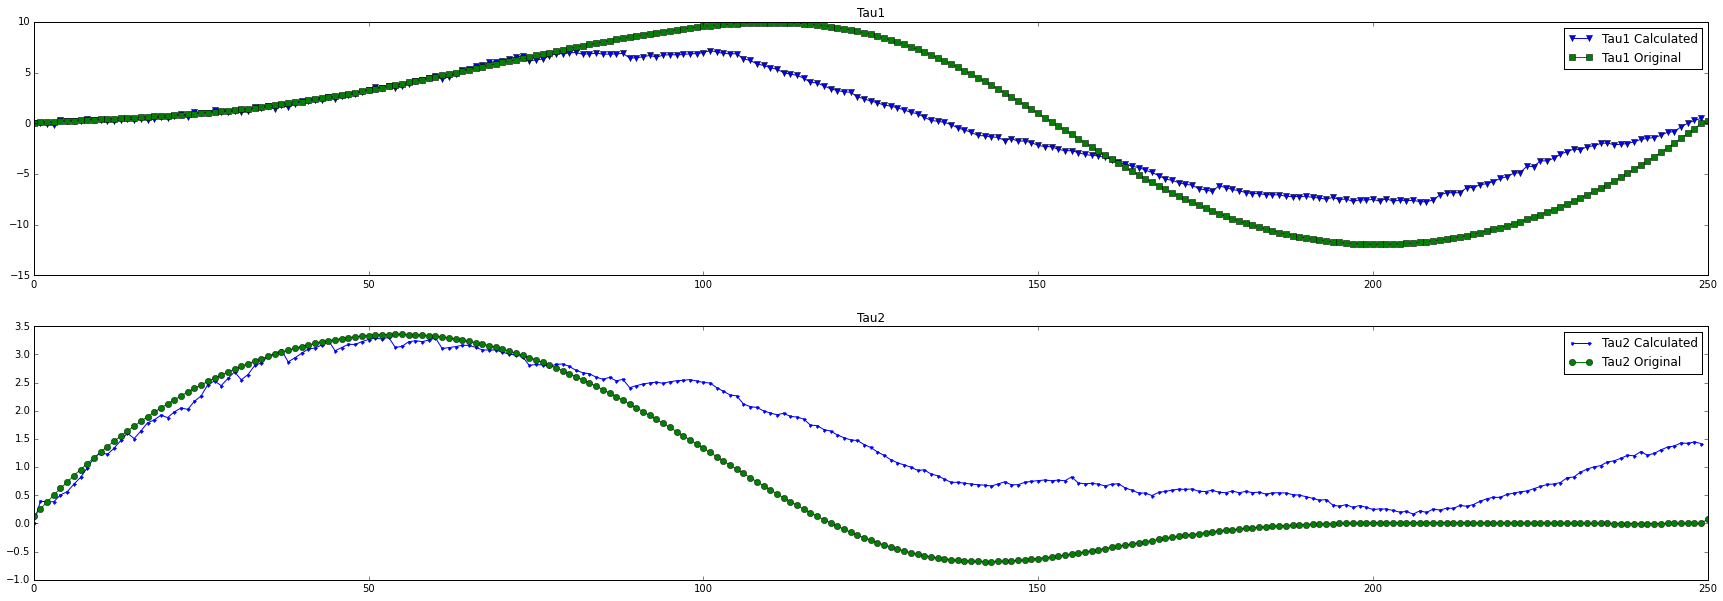

In [17]:
run_number=25
tji=1
noiselevel=0
decimationlevel=0
x_lsm,y_lsm,xstart,ystart,xdest,ydest = generates_lsm_start(tji,trajectories,x_values,y_values)

torques = slf.load_from_file("./"+base_dir+"/"+sim_set+"/torques_"+str(tji)+"_noise_level_"+str(noiselevel)+"_killed_neurons_"+str(decimationlevel)+"_run_"+str(run_number)+".pickles")

ymin = numpy.array([torques_all_1.min(),torques_all_2.min()]).min()
ymax = numpy.array([torques_all_1.max(),torques_all_2.max()]).max()
plt.figure(figsize =(30,10))
plt.subplot(2,1,1)
plt.plot(torques[:,0],'v-',label="Tau1 Calculated")
plt.plot(torques_all_1[(tji-1)*250:(tji+1)*250],'s-',label="Tau1 Original")
plt.title("Tau1")
plt.xlim(0,250)
plt.legend()

plt.subplot(2,1,2)
plt.plot(torques[:,1],'.-',label="Tau2 Calculated")
plt.plot(torques_all_2[(tji-1)*250:(tji+1)*250],'o-',label="Tau2 Original")
plt.xlim(0,250)
plt.title("Tau2")
# plt.ylim(ymin,ymax)
plt.legend()

plt.show()

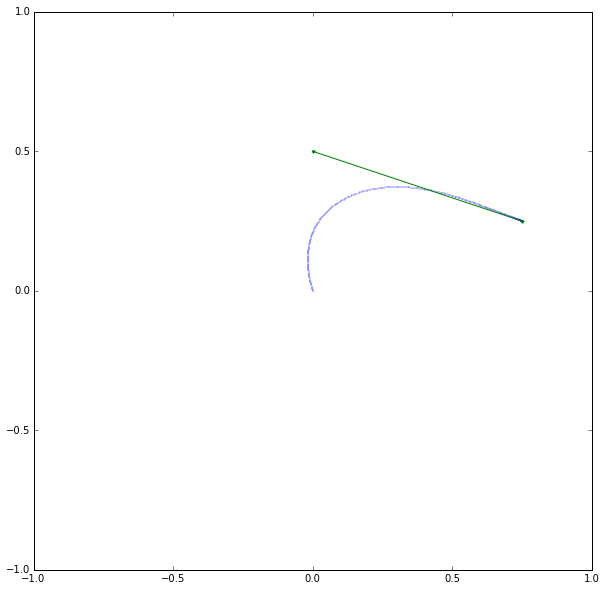

In [23]:
run_number=1
tji=1
noiselevel=0
decimationlevel=0
x_lsm,y_lsm,xstart,ystart,xdest,ydest = generates_lsm_start(tji,trajectories,x_values,y_values)

teta = slf.load_from_file("./"+base_dir+"/"+sim_set+"/teta_"+str(tji)+"_noise_level_"+str(noiselevel)+"_killed_neurons_"+str(decimationlevel)+"_run_"+str(run_number)+".pickles")

H,E = joints_to_hand(teta,aparams)

plt.figure(figsize =(10,10))
plt.plot(H[:,0],H[:,1],'.',markersize=1)
plt.plot([xstart,xdest],[ystart,ydest],'.-')
plt.xlim(-1,1)
plt.ylim(-1,1)
plt.show()

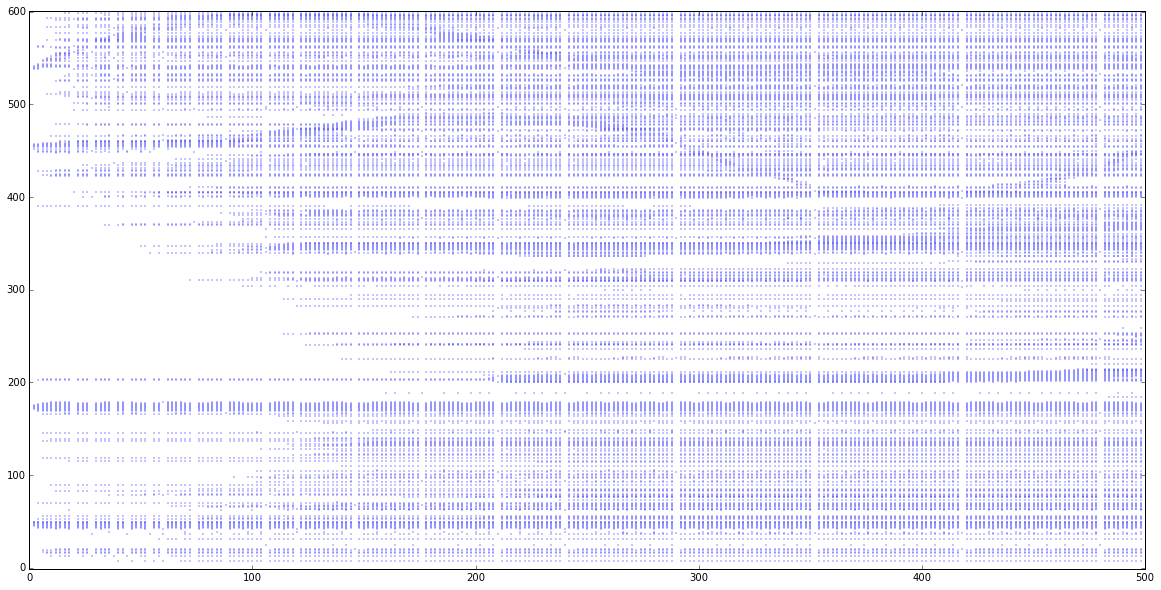

In [19]:
run_number=1
tji=1
noiselevel=0
decimationlevel=0
x_lsm,y_lsm,xstart,ystart,xdest,ydest = generates_lsm_start(tji,trajectories,x_values,y_values)

OutputSpks_save = slf.load_from_file("./"+base_dir+"/"+sim_set+"/OutputSpks_save_"+str(tji)+"_noise_level_"+str(noiselevel)+"_killed_neurons_"+str(decimationlevel)+"_run_"+str(run_number)+".pickles")

y = numpy.array([j for i in OutputSpks_save for j in i[0]])
x = numpy.array([i[1] for i in OutputSpks_save for j in i[0]])

plt.figure(figsize =(20,10))
plt.plot(x*1000,y,'.',markersize=1)
# plt.xlim(-1,251)
plt.ylim(-1,601)
plt.show()